#Train with a large dataset: Cats and dogs
In this codelab, you'll look at a real and very large dataset, and see the impact that it has on avoiding overfitting.

First, set up your development environment with the requisite libraries that you'll need.

In [1]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

#Get the data
The full dataset for the kaggle challenge is provided by Microsoft.

In [6]:
!wget --no-check-certificate \
    https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip \
    -O "/tmp/cats-and-dogs.zip"
local_zip = '/tmp/cats-and-dogs.zip'

#Check file size
!ls -lh $local_zip

#Check to see if the file is a valid zip file
!file $local_zip

# Create a ZipFile object
zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))
# Expected Output:
# 12501
# 12501

--2024-08-31 12:19:02--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.199.49.187, 2600:1408:20:c84::317f, 2600:1408:20:c8b::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.199.49.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   107MB/s    in 8.3s    

2024-08-31 12:19:11 (94.7 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]

-rw-r--r-- 1 root root 787M May  9  2022 /tmp/cats-and-dogs.zip
/tmp/cats-and-dogs.zip: Zip archive data, at least v2.0 to extract, compression method=store
12501
12501


#Prepare the data
Now that you downloaded the data, unzip it into training and testing directories. The following code achieves that:

In [7]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)
# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


You can check to see if your data is properly unpacked using the following code:

In [8]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))
# Expected output:
# 11250
# 11250
# 1250
# 1250

11250
11250
1250
1250


#Define the model
Next, define the model as a series of convolutional layers with max pooling.

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#Train the model
Now that the model is defined, you can train the model using an ImageDataGenerator.

In [11]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


To train the model, you now call model.fit_generator, passing it to the generators that you created.

In [13]:
# Note that this may take some time.
history = model.fit(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 15/225 ━━━━━━━━━━━━━━━━━━━━ 7:32 2s/step - accuracy: 0.4815 - loss: 1.7222

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 ━━━━━━━━━━━━━━━━━━━━ 503s 2s/step - accuracy: 0.5688 - loss: 0.8220 - val_accuracy: 0.7096 - val_loss: 0.5484
Epoch 2/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 498s 2s/step - accuracy: 0.7172 - loss: 0.5505 - val_accuracy: 0.7396 - val_loss: 0.5236
Epoch 3/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 499s 2s/step - accuracy: 0.7687 - loss: 0.4764 - val_accuracy: 0.8088 - val_loss: 0.4062
Epoch 4/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 494s 2s/step - accuracy: 0.8029 - loss: 0.4222 - val_accuracy: 0.8504 - val_loss: 0.3503
Epoch 5/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 487s 2s/step - accuracy: 0.8278 - loss: 0.3768 - val_accuracy: 0.8200 - val_loss: 0.3956
Epoch 6/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 515s 2s/step - accuracy: 0.8571 - loss: 0.3292 - val_accuracy: 0.8908 - val_loss: 0.2602
Epoch 7/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 493s 2s/step - accuracy: 0.8842 - loss: 0.2744 - val_accuracy: 0.9464 - val_loss: 0.1792
Epoch 8/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 498s 2s/step - accuracy: 0.9149 - loss: 0.2136 - val_accuracy: 0.968

#Explore the results
You can explore and plot the training and validation accuracy with the following code. Use it to see when you reach maximum training efficiency and see whether you're overfitting.

<Figure size 640x480 with 0 Axes>

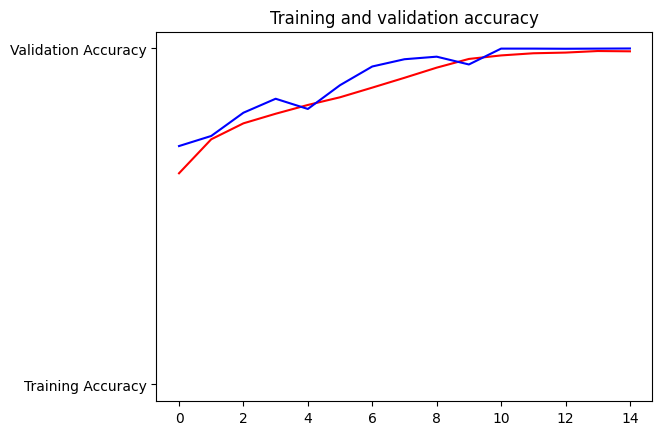

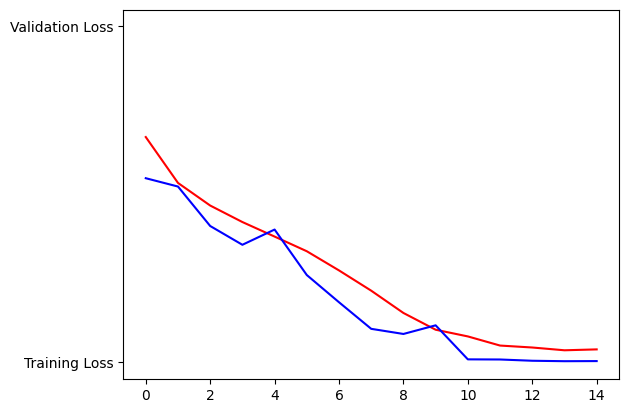

<Figure size 640x480 with 0 Axes>

In [14]:
%matplotlib inline
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()

#Test your model
If you want to take the model for a spin, you can use the following code. Upload images to see how it classifies them!

In [15]:
# Here's a codeblock just for fun. You should be able to upload an image here
# and have it classified without crashing
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")